In [1]:
%%HTML
<script src="require.js"></script>

In [62]:
from IPython.display import HTML


HTML("""<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

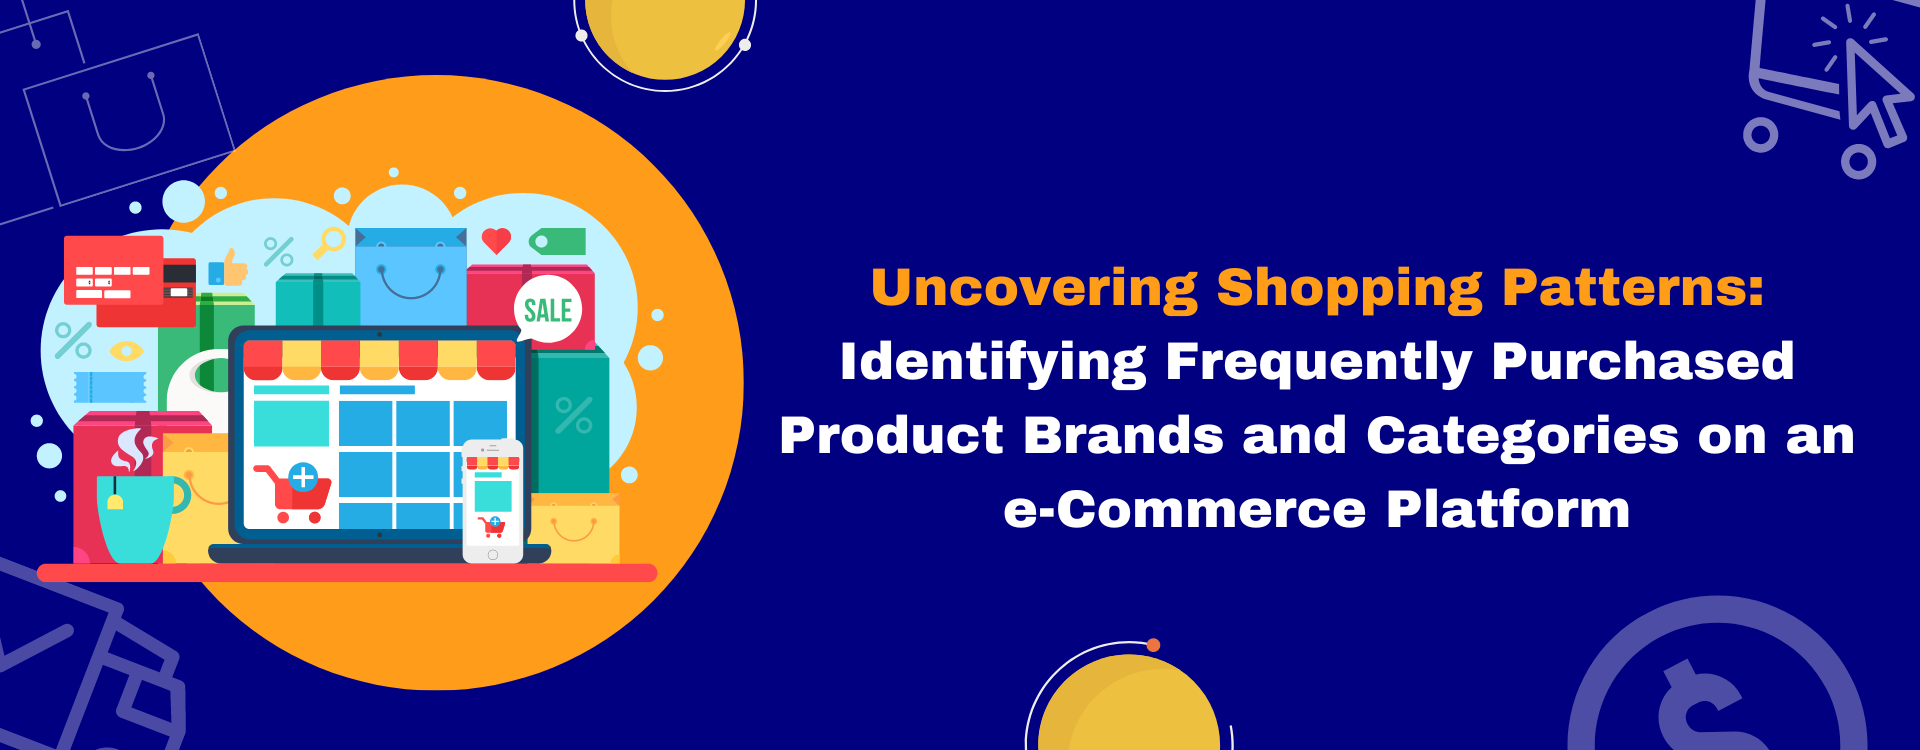

<a id='ExecSum'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">EXECUTIVE SUMMARY</h1>

In this study, the team performed Frequent Itemset Analysis (FIM) on an e-commerce Behavior Dataset in order to determine the frequently bought product brands and categories. It is easy to be overwhelmed with the influx of information in the ever-growing e-commerce industry. In effect, it is also difficult for businesses to handle such large data and leverage it for business strategy and ultimately for business profit. The dataset that the team worked on comprised of $4,168,088$ rows and $7$ columns. It covers the months of November to December 2019.

Before proceeding to the methodology, the team encountered different prices for one product. To handle it, the team took the average price and assigned that as the constant price for it. The methodology used in this project heavily focused on the Data Exploration as it is an important foundation before the implementation of the FIM Algorithm. The team has discovered two insights that pivoted the study to a narrower scope: 
1. The transactions between `cart` and `purchase` transactions are essentially the same which pivoted the study to focus on `purchase` transactions only.
1. The dataset categories is heavily dominated by `electronics`, `computers`, and `appliances`. 

In order to do a more holistic study, the team aggregated the minor categories into one category called `others`. Moving forward, the team only performed FIM analysis on these categories (aka Major Categories). The FIM algorithm was implemented to each Major Category, and with a `supp=-20`, the results show that for each category, the FIM analysis was limited to identifying frequent $2$-itemsets, and only a few extended to $3$-itemsets. Based on the results, the business owner can leverage the information to perform the following analysis techniques: **Market Basket Analysis**, **Inventory Management**, and **Personalization**. Overall, despite the limitations, especially the lack of product description, the team is able to determine the frequently purchased product brands and categories to generate insights and recommendations for an e-commerce company.

<a id='TContents'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">TABLE OF CONTENTS</h1>

[EXECUTIVE SUMMARY](#ExecSum) <br> 
[IMPORT LIBRARIES AND DEFINE FUNCTIONS](#Libraries) <br> 
[LIST OF TABLES AND FIGURES](#Tables) <br> 

[1. PROBLEM STATEMENT](#Problem) <br> 
[2. MOTIVATION](#Motiv) <br> 
[3. METHODOLOGY](#Methodology) <br> 
[3.1. DATA COLLECTION](#Collection) <br> 
- [Data Source](#Source) <br>
- [Data Description](#Description) <br>
- [Data Collection and Database Creation](#CC) <br>

[3.2 DATA EXPLORATION](#Exploration) <br> 
- [Data Preprocessing](#Prep) <br>
- [Exploratory Data Analysis](#EDA) <br>
- [Frequent Itemset Mining](#FIM) <br>

[4. RESULTS AND DISCUSSION](#Results) <br>
[5. RECOMMENDATION](#Recommendation1) <br> 
- [Limitations of the Study](#Limitations)
- [Recommendation](#Recommendation2) <br>
- [Future Work](#FutureWork) <br> 

[6. CONCLUSION](#Conclusion) <br> 
[REFERENCES](#References) <br> 

<a id='Libraries'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">IMPORT LIBRARIES</h1>

This section involves importing the necessary libraries and defining the required functions, including global libraries and helper functions, and procedural functions for data preparation. This step lays the foundation for the subsequent analysis and modeling steps.

<h2 style="color:#000080">A. Global Libraries & Functions</h2> 

This step involves importing global libraries and defining global helper functions that will be used throughout the notebook.

<h3 style="color:#222f3e">A1. Global Libraries</h3>

In [5]:
# Libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fim
import sqlite3
import re
import os
import joblib
from PIL import Image
import pickle
from urllib.parse import urljoin
from tqdm.notebook import tqdm, trange
import warnings
from sklearn.exceptions import ConvergenceWarning
from IPython.display import display, display_html

# Global settings
%matplotlib inline

# Pandas settings
# pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('mode.chained_assignment', None)

# Error Filters
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

<h3 style="color:#222f3e"> A2. Global Helper Functions</h3>

In [6]:
def preview_df(df, display_df=True):
    """Displays the number of data points, nulls, statistics, and preview
    of the dataframe."""
    display_html(f'<b>Number of Data Points:</b> {df.shape[0]}',
                 raw=True)
    display_html(f'<b>Number of Features:</b> {df.shape[1]}',
                 raw=True)
    display_html(f'<b>Number of Nulls:</b> {df.isna().any(axis=1).sum()}',
                 raw=True)
    if display_df:
        # Display first 3 rows of the df
        print(f'First three rows of the df:\n')
        display(df.head(3))
        # Get summary statistics for the numerical columns and transpose the
        # DataFrame for more readable output
        print(f'\nSummary statistics for numerical columns:\n')
        display(df.describe())
    else:
        print('Count of missing values:')
        display(df.isna().sum())
        
def get_table_info(cursor, table_name):
    cursor.execute(f"PRAGMA table_info({table_name});")
    return cursor.fetchall()

def get_row_count(cursor, table_name):
    cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
    return cursor.fetchone()[0]

def save_pkl(obj, name, prompt=False):
    """Save an object to a pickle file."""
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        os.makedirs(folder)
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    joblib.dump(obj, fp)
    if prompt:
        print('Object pickled for future use.')
    return

def load_pkl(name, prompt=False):
    """Load an object from a pickle file."""
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        raise ValueError("'pickles' folder does not exist.")
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    pkl = joblib.load(fp)
    if prompt:
        print('Pickle file loaded.')
    return pkl

# Helper functions for EDA
def get_major_cats(category='electronics'):
    """
    Return the category name if the input is 'electronics', or 'appliances',
    or 'computers'. Otherwise, return 'others'.
    """
    if category=='electronics' or category=='appliances' \
                               or category=='computers':
        return category
    else:
        return 'others'
    
def plot_major_categories(df, criterion='electronics'):
    """
    Plot the count of the top 10 subcategories under 'Major Category'.
    """
    plt.figure(figsize=(8, 5))
    mask = df['major_cat']==criterion
    result = df[mask]['subcat1'].value_counts().head(10)

    result.plot(kind='barh', color=c_darkblue).invert_yaxis()
    length = len(result)
    for i in range(length):
        max_x = max(result.tolist())
        if result.tolist()[i] > max_x * 0.75:
            plt.text(result.tolist()[i]-(max_x*0.10), i+0.1, 
                     result.tolist()[i], color='white', fontsize=10,
                     weight='bold')
        else: 
            plt.text(result.tolist()[i]+(max_x*0.010), i+0.1, 
                     result.tolist()[i], color='black', fontsize=10,
                     weight='bold')
    if len(df[mask]['subcat1'].value_counts().tolist()) > 10:
        plt.title(f'Count of sub-categories under "{criterion}" (top 10 only)',
                  fontsize=14, weight='bold')
    else:
        plt.title(f'Count of sub-categories under "{criterion}"',
                  fontsize=14, weight='bold')
        
    plt.show();
    
def plot_products_per_category(df, category, action):
    """
    Plot the number of products purchased or added to cart by 
    users according    to the product category."""
    plt.figure(figsize=(8, 5))
    result = df[category].value_counts().head(10)
    result.plot(kind='barh', color=c_darkblue).invert_yaxis()
    length = len(result)
    for i in range(length):
        max_x = max(result.tolist())
        if result.tolist()[i] > max_x * 0.75:
            plt.text(result.tolist()[i]-(max_x*0.12), i+0.1, 
                     result.tolist()[i], color='white', fontsize=10,
                     weight='bold')
        else: 
            plt.text(result.tolist()[i]+(max_x*0.010), i+0.1, 
                     result.tolist()[i], color='black', fontsize=10,
                     weight='bold')
    if len(df[category].value_counts().tolist()) > 10:
        plt.title(f'Number of Unique Products per "{category}" in "{action}"'\
                  ' Transactions (top 10 only)',
                  fontsize=14, weight='bold')
    else:
        plt.title(f'Number of Unique Products per "{category}" in "{action}"'\
                  ' Transactions', fontsize=14, weight='bold')
    plt.show();

# Global variables
c_darkblue = '#000080'

In [7]:
db_path = load_pkl('db_path')
conn = sqlite3.connect(db_path)

<h3 style="color:#222f3e">B. Database Creation Functions</h3>

In [8]:
def build_product_id_db(table='purchases', main_cat=None):
    """
    Create a transaction database where the items are product ids and the
    transactions are user_sessions.
    """
    global conn
    try:
        product_id_db = load_pkl(
            f'{table}_{main_cat}_product_id_db', prompt=True
        )
    except:
        if main_cat is not None:
            query = f'''
                SELECT user_session, {table}.product_id
                FROM {table}
                LEFT JOIN products ON
                {table}.product_id = products.product_id
                WHERE products.category_code LIKE '%{main_cat}%'
            '''
        else:
            query = f'''
                SELECT user_session, product_id
                FROM {table}
            '''
        product_id_db = (
            pd.read_sql(query, conn).groupby('user_session')
            .product_id.apply(set).tolist()
        )
        save_pkl(product_id_db,
                 f'{table}_{main_cat}_product_id_db',
                 prompt=True)
    return product_id_db

def build_brand_category_code_db(table='purchases', main_cat=None):
    """
    Create a transaction database where items are the brand plus the deepest
    category code of each product and the transactions are the user sessions.
    """
    global conn
    try:
        brand_category_code_db = load_pkl(
            f'{table}_{main_cat}_brand_category_code_db', prompt=True
        )
    except:
        if main_cat == 'others':
            other_codes = ['apparel', 'auto', 'construction', 'furniture',
                           'kids', 'accessories', 'sport', 'medicine',
                           'stationery', 'country_yard']
            df_list = []
            for cat in other_codes:
                query = f'''
                    SELECT user_session, brand, category_code
                    FROM {table}
                    LEFT JOIN products ON
                    {table}.product_id = products.product_id
                    WHERE products.category_code LIKE '%{cat}%'
                '''
                df_list.append(pd.read_sql(query, conn))
            brand_category_code_df = pd.concat(df_list)
        elif main_cat is not None:
            query = f'''
                SELECT user_session, brand, category_code
                FROM {table}
                LEFT JOIN products ON
                {table}.product_id = products.product_id
                WHERE products.category_code LIKE '%{main_cat}%'
            '''
        else:
            query = f'''
                SELECT user_session, brand, category_code
                FROM {table}
                LEFT JOIN products ON
                products.product_id = products.product_id
            '''

        if main_cat != 'others':
            brand_category_code_df = pd.read_sql(query, conn)
        brand_category_code_df.category_code = (
            brand_category_code_df.category_code.str.extract(r'\.?([a-z]+)$')
        )
        brand_category_code_df['brand_category_code'] = (
            brand_category_code_df.brand +
            '.' +
            brand_category_code_df.category_code
        )
        brand_category_code_db = (
            brand_category_code_df.groupby('user_session')
            .brand_category_code.apply(set).tolist()
        )
        save_pkl(brand_category_code_db, 
                 f'{table}_{main_cat}_brand_category_code_db',
                 prompt=True)
    return brand_category_code_db

def build_category_code_db(table='purchases', main_cat=None):
    """
    Create a transaction database where items are the brand plus the deepest
    category code of each product and the transactions are the user sessions.
    """
    global conn
    try:
        category_code_db = load_pkl(
            f'{table}_{main_cat}_category_code_db', prompt=True
        )
    except:
        if main_cat == 'others':
            other_codes = ['apparel', 'auto', 'construction', 'furniture',
                           'kids', 'accessories', 'sport', 'medicine',
                           'stationery', 'country_yard']
            df_list = []
            for cat in other_codes:
                query = f'''
                    SELECT user_session, brand, category_code
                    FROM {table}
                    LEFT JOIN products ON
                    {table}.product_id = products.product_id
                    WHERE products.category_code LIKE '%{cat}%'
                '''
                df_list.append(pd.read_sql(query, conn))
            category_code_df = pd.concat(df_list)
        elif main_cat is not None:
            query = f'''
                SELECT user_session, brand, category_code
                FROM {table}
                LEFT JOIN products ON
                {table}.product_id = products.product_id
                WHERE products.category_code LIKE '%{main_cat}%'
            '''
        else:
            query = f'''
                SELECT user_session, brand, category_code
                FROM {table}
                LEFT JOIN products ON
                products.product_id = products.product_id
            '''
        if main_cat != 'others':
            category_code_df = pd.read_sql(query, conn)
        category_code_df.category_code = (
            category_code_df.category_code.str.extract(r'\.?([a-z]+)$')
        )
        category_code_db = (
            category_code_df.groupby('user_session')
            .category_code.apply(set).tolist()
        )
        save_pkl(category_code_db,
                 f'{table}_{main_cat}_category_code_db',
                 prompt=True)
    return category_code_db

<h3 style="color:#222f3e">C. Frequent Itemset Functions</h3>

In [9]:
# FIM
def get_freq(db, supp=1, k=1, L=10):
    """
    Get the top L frequent k-itemsets in the database.
    """
    return [
        (tuple(sorted(itemset)), supp) for itemset, supp in
        sorted(fim.fpgrowth(db, supp=supp, zmin=k),
               key=lambda x: (-x[1], x[0]))[:L]
    ]

# For 1-itemsets only
def flatten_itemsets(set_list):
    """
    Flattens the list of frequent itemsets to list of items.
    """
    freq = []
    supports = []
    for iset, supp in set_list:
        freq.extend(list(iset))
        supports.append(supp)
    return freq, supports

# Only for product_id_db
def get_metadata(id_list, items=False):
    """
    Get the metadata of the given `product_id`s.
    """
    global conn
    iset, supports = id_list
    query = f'''
        SELECT *
        FROM products
        WHERE product_id IN {tuple(iset)}
    '''
    df = pd.read_sql(query, conn)
    if items:
        return df.join(pd.Series(supports, name='support'))
    return df

def display_frequent_itemsets(db, supp=1, k=1, items=False,
                              product_id_db=False):
    """
    Display the metadata of the list of top frequent itemsets.
    """
    global conn
    if product_id_db:
        if items:
            freq_sets = flatten_itemsets(
                    get_freq(db, supp=supp, k=k)
                )
            display(get_metadata(freq_sets, items))
        else:
            freq_sets = get_freq(db, supp=supp, k=k)
            for iset in freq_sets:
                display(get_metadata(iset, items))
    else:
        if items:
            freq_sets = flatten_itemsets(
                    get_freq(db, supp=supp, k=k)
                )
        else:
            freq_sets = get_freq(db, supp=supp, k=k)
    return freq_sets

def discard_supp(freqsets):
    """
    Discard the supports of a list of frequent itemsets.
    """
    return list(zip(*freqsets))[0]

def get_assoc_rules(db, supp=-20, conf=60):
    """
    Get association rules for the transaction database.
    """
    results = fim.fpgrowth(db, supp=supp, conf=conf, target='r', report='l')
    sorted_rules = sorted(
        [(cons, tuple(sorted(ante)), lift) for cons, ante, lift in results],
        key=lambda x: (-x[-1], x[0], x[1])
    )
    return pd.DataFrame(sorted_rules,
                        columns=['consequent', 'antecedent', 'lift'])

[Back to TOC](#TContents)

<a id='Tables'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">LIST OF TABLES AND FIGURES</h1>

## Tables

- Table 1: Methodology Details
- Table 2: Data Description of Features Selected
- Table 3: SQL Database Information
- Table 4: Data Description of Features Dropped
- Table 5. Taking the Mean Price of a Product across All Events
- Table 6. Expanding the Category Code Levels as New Columns

## Figures

- Figure 1: Problem Statement
- Figure 2: Methodology
- Figure 3: Count per Main Category in Cart Transactions
- Figure 4: Count per Main Category in Purchase Transactions
- Figure 5: Count per Sub Category 1 in Purchase Transactions
- Figure 6: Count per Sub Category 2 in Purchase Transactions
- Figure 7: Count per Sub Category 3 in Purchase Transactions
- Figure 8: Purchase Count per Major Category
- Figure 9: Purchase Count per Sub Category under Electronics
- Figure 10: Purchase Count per Sub Category under Appliances
- Figure 11: Purchase Count per Sub Category under Computers
- Figure 12: Purchase Count per Sub Category under Others
- Figure 13. Results for the Electronics Main Category
- Figure 14. Results for the Appliances Main Category
- Figure 15. Results for the Computers Main Category
- Figure 16. Results for the Others Main Category

[Back to TOC](#TContents)

<a id='Problem'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">PROBLEM STATEMENT</h1>

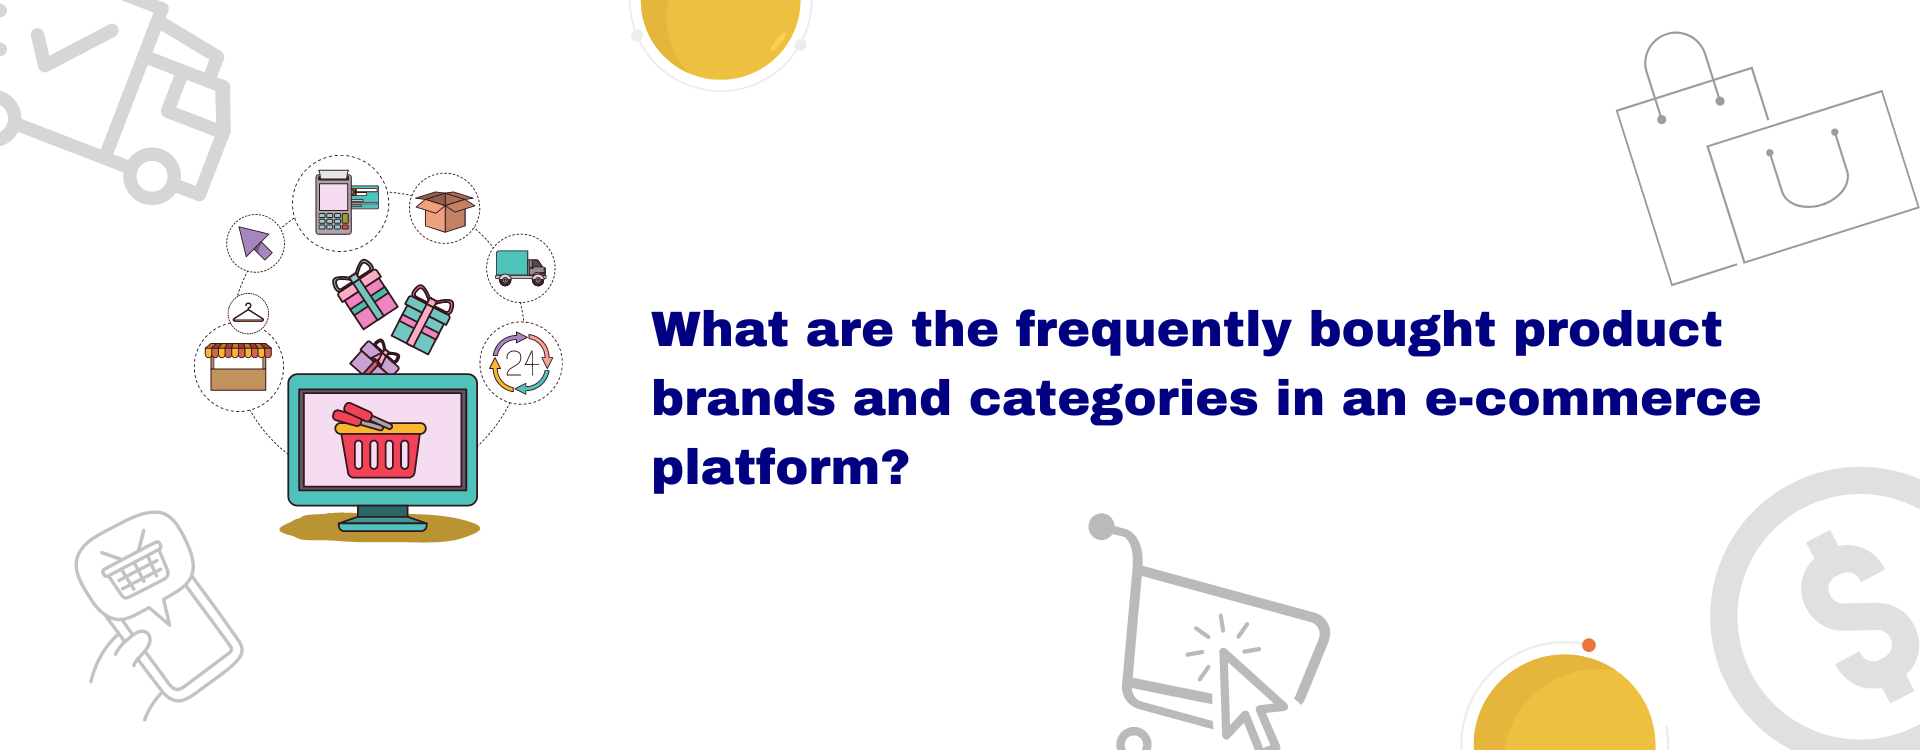
<center><span style="font-size:14px"><b>Figure 1. </b>Problem Statement</span></center>

[Back to TOC](#TContents)

<a id='Motiv'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">MOTIVATION</h1>

E-commerce, short for electronic commerce, refers to the buying and selling of goods and services online. With the rise of technology and the internet, e-commerce has become an essential part of many industries, from retail and entertainment to healthcare and finance. E-commerce platforms enable businesses to reach a wider audience, offer a more personalized shopping experience, and provide greater convenience for customers. Additionally, e-commerce has given rise to new business models, such as dropshipping and subscription-based services, that were not feasible in the traditional brick-and-mortar retail space. As a result, e-commerce has become a crucial driver of economic growth and innovation.

As such, E-commerce has paved the way for a new era of shopping, transforming the traditional retail landscape and revolutionizing the way consumers shop. The vast amount of information provided by e-commerce has overwhelmed many consumers, making it difficult for them to sort through and process the sheer volume of product offerings, reviews, and other data available online. **The same is true for businesses**. With such an overwhelming amount of transactions to monitor, it can be difficult to analyze the shopping patterns of the consumers.

Thus, by performing Frequent Analysis Itemset (FIM), it can be easier to uncover patterns and associations in large datasets such as purchases on an e-commerce platform. Valuable insights can be gained and used to inform marketing strategies, improve product offerings, and ultimately increase sales and customer satisfaction. By analyzing e-commerce purchase data with FIM, the potential of these datasets can be unlocked and their full value can be leveraged for business success.

[Back to TOC](#TContents)

<a id='Methodology'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">METHODOLOGY</h1>

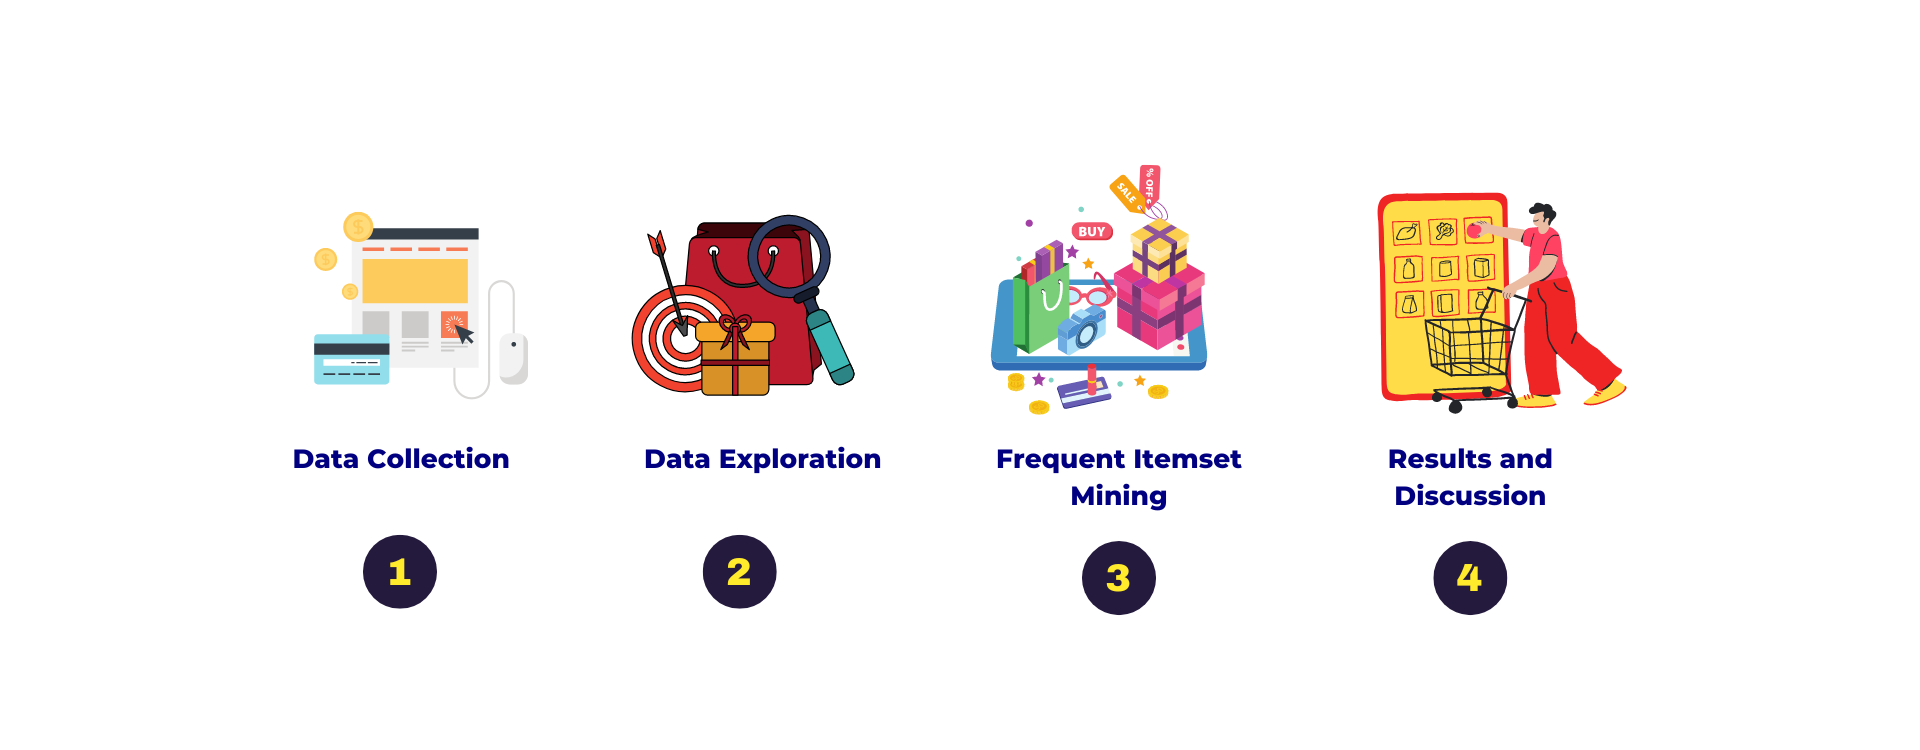
<center><span style="font-size:14px"><b>Figure 2. </b>Methodology</span></center>

<table >
    <tr style="color:#ffffff; background-color:#000080">
        <th style="text-align: left">No.</th>
        <th style="text-align: left">Step</th>
        <th style="text-align: left">Description</th>
    </tr>
    <tr>
        <td style="text-align: left">1.</td>
        <td style="text-align: left; font-weight: bold; color:#000080;">Data Collection</td>
        <td style="text-align: left">Collect publicly available e-Commerce Behavior Dataset focusing on specific event transactions 'cart' and 'purchase'. Then store the collected data in an SQL database.</td>
    </tr>
    <tr>
        <td style="text-align: left">2.</td>
        <td style="text-align: left; font-weight: bold; color:#000080;">Data Exploration</td>
        <td style="text-align: left">Prepare and clean the collected dataset to ensure its quality and suitability for further analysis. Perform EDA to explore and understand the relationships between the features, identify any trends/patterns, and provide insights regarding the e-Commerce Behavior Dataset.</td>
    </tr>
    <tr>
        <td style="text-align: left">3.</td>
        <td style="text-align: left; font-weight: bold; color:#000080;">Frequent Itemset Mining</td>
        <td style="text-align: left">Perform Frequent Itemset Mining (FIM) in order to find out what items and bundles of items are frequently added to a cart and purchased. </td>
    </tr>
    <tr>
        <td style="text-align: left">4.</td>
        <td style="text-align: left; font-weight: bold; color:#000080;">Results and Discussion</td>
        <td style="text-align: left">Based on the results from the Frequent Itemset Mining algorithm, provide insights on each result. Then summarize the results, benefits, disadvantages, recommendations, and conclusion. </td>
    </tr>
</table>
<br>
<center><span style="font-size:14px"><b>Table 1. </b>Methodology Details</span></center>

<a id='Collection'></a>
<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">Data Collection</h2>

The data collection section involves three key steps:
1. Identifying the data source;
1. Describing the data; and
1. Collecting and storing the data into an SQL database.

<a id='Source'></a>
### <u>Data Source</u>

The team used two (2) datasets from the 'E-commerce Behavior Data' made available to the team via the jojie-collected public datasets (directory: `/mnt/data/public/ecommerce-behavior-data`) of the Asian Institute of Management (AIM) which is also available in Kaggle [3]. This dataset was originally downloaded from Kaggle (link: `https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store`) which is a dataset on consumer behavior data for seven (7) months (from October 2019 to April 2020) from a large multi-category online store operating in a certain country in the Middle East [1]. It covers transactions of users on four (4) event types:

1. **view** - an event type which entails that the user `viewed` a product.
2. **cart** - an event type which entails that the user `added` a product to a shopping cart.
3. **remove_from_cart** - an event type which entails that the user `removed` a product from a shopping cart.
4. **purchase** - an event type which entails that the user `purchased` a product.

In this study, the team only extracted the data on event types **`cart`** and **`purchase`** and transactions from **`October to November 2019`**. The datasets are originally in a Comma-separated values (.csv) file format and were collected and uploaded into an SQL database. After collecting and preprocessing the data, the team was able to gather and use 4,168,088 rows and 7 columns.

<a id='Description'></a>
### <u>Data Description</u>

The following features were used and considered relevant for this report:

<table >
    <tr style="color:#ffffff; background-color:#000080">
        <th style="text-align: left">Feature Name</th>
        <th style="text-align: left">Feature Description</th>
        <th style="text-align: left">Data Type</th>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">event_time</td>
        <td style="text-align: left">Date of the transaction.</td>
        <td style="text-align: left">date</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">product_id</td>
        <td style="text-align: left">Unique ID of the product.</td>
        <td style="text-align: left">integer</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">user_id</td>
        <td style="text-align: left">Unique ID of the user.</td>
        <td style="text-align: left">integer</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">user_session</td>
        <td style="text-align: left">Unique ID of each session of the user.</td>
        <td style="text-align: left">text</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">category_code</td>
        <td style="text-align: left">Unique code of the product category.</td>
        <td style="text-align: left">text</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">brand</td>
        <td style="text-align: left">Specific brand of the product.</td>
        <td style="text-align: left">text</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">mean_price</td>
        <td style="text-align: left">Average price of the product.</td>
        <td style="text-align: left">float</td>
    </tr>
</table>
<br>
<center><span style="font-size:14px"><b>Table 2. </b>Data Description of Features Selected</span></center>

<a id='CC'></a>
### <u>Data Collection and Database Creation</u>

The team uploaded the processed data into a db file and uploaded to an sqlite database for easier access and more flexibility in data manipulation. The database contains the following information:

<table >
    <tr style="color:#ffffff; background-color:#000080">
        <th style="text-align: left">Table</th>
        <th style="text-align: left">Columns</th>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">purchase</td>
        <td style="text-align: left">event_time, product_id, user_id, user_session</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">carts</td>
        <td style="text-align: left">event_time, product_id, user_id, user_session</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">products</td>
        <td style="text-align: left">product_id, category_code, brand, mean_price</td>
    </tr>
</table>
<br>
<center><span style="font-size:14px"><b>Table 3. </b>SQL Database Information</span></center>

[Back to TOC](#TContents)

<a id='Exploration'></a>
<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">Data Exploration</h2>

This section involves preparing and cleaning the collected dataset to ensure its quality and suitability for further analysis, followed by performing exploratory data analysis (EDA) to understand the relationships between the features, identify trends and patterns, and gain insights into the E-Commerce Behavior dataset.

<a id='Prep'></a>
### <u>Data Preprocessing</u>

#### A. Drop Features

The following features were dropped which are deemed not necessary in the study: 

<table >
    <tr style="color:#ffffff; background-color:#000080">
        <th style="text-align: left">Feature Name</th>
        <th style="text-align: left">Feature Description</th>
        <th style="text-align: left">Data Type</th>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">event_type</td>
        <td style="text-align: left">Type of transaction: 'view','cart','remove_from_cart', and 'purchase'.</td>
        <td style="text-align: left">text</td>
    </tr>
    <tr>
        <td style="text-align: left; font-weight: bold; color:#000080;">category_id</td>
        <td style="text-align: left">Unique ID of the category + brand.</td>
        <td style="text-align: left">integer</td>
    </tr>
</table>
<br>
<center><span style="font-size:14px"><b>Table 4. </b>Data Description of Features Dropped</span></center>

**Notes**:

- For the **`event_type`** the team initially intended to create a separate analysis on `cart` and `purchase` and thereby created a separate database for each.
- For the **`category_id`** the team have deemed it unncessary because it is redundant and ambiguous. The information it entails can already be inferred from the `category_code` and `brand` features. It is ambiguous in the sense that it is a unique ID for the combination of category and brand features and not particularly for the category feature, which was initially the team had thought it to be. Thus, to prevent any confusion, this feature was dropped. 

#### B. Treatment on the Difference in Price per Product

The team have noticed that a product corresponds to different prices. The team inferred that this might be because of special events such as platform sales promotions which would entail discounted prices. After further research on the dataset information, the team have confirmed that this is the case. [2] Therefore, to handle this data, the team calculated the mean price of the product and used it as a constant value for that item. A sample of this incident is show below:

In [59]:
df_pkl = load_pkl('ecom.pkl')

display(HTML(
    '<center>' +
    df_pkl.head(10).to_html(index=False)
    + '</center>'
))

display(HTML(
    '<center>' +
    pd.read_sql('''
    SELECT product_id, mean_price
    FROM products
    WHERE product_id == 1004856
    ''', conn).to_html(index=False)
    + '</center>'
))


<center><span style="font-size:14px"><b>Table 5. </b>Taking the Mean Price of a Product across All Events</span></center>

[Back to TOC](#TContents)

<a id='EDA'></a>
### <u>Exploratory Data Analysis</u>

In [11]:
product_df = pd.read_sql("""
    SELECT *
    FROM products
    """, conn)           
                        
cart_df = pd.read_sql("""
    SELECT *
    FROM carts as c
    JOIN products as p ON c.product_id = p.product_id
    """, conn)
    
purchase_df = pd.read_sql("""
    SELECT *
    FROM purchases as purch
    JOIN products as p ON purch.product_id = p.product_id
    """, conn)

cat_cols = ['main_cat', 'subcat1', 'subcat2', 'subcat3']
product_df[cat_cols] = product_df['category_code'].str.split('.',
                                                             expand=True)
cart_df[cat_cols] = cart_df['category_code'].str.split('.',
                                                       expand=True)
purchase_df[cat_cols] = purchase_df['category_code'].str.split('.',
                                                               expand=True)

#### A. Expanding the `category_code`

In this section, the team separated the categories from the `category_code` feature that are separated by a period `.` **to create and perform analysis on the sub categories of each product.** The format of this separation is summarized below:

Example `category_code`: 'electronics.audio.headphone', separated into:
- `main_cat`: 'electronics'
- `subcat1`: 'audio'
- `subcat2`: 'headphone'
- `subcat3`: 'None'

In [12]:
display(HTML(
    '<center>' +
    product_df[product_df.category_code ==
               'electronics.audio.headphone']
    .head().to_html(index=False)
    + '</center>'
))

<center><span style="font-size:14px"><b>Table 6. </b>Expanding the Category Code Levels as New Columns</span></center>

#### B. Performing EDA on expanded category_codes of `cart` transactions

##### Main Category

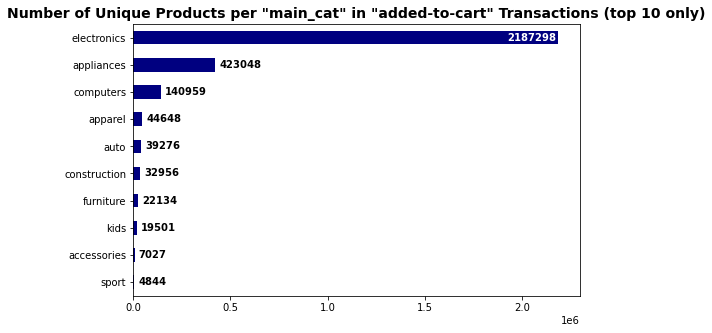

In [13]:
plot_products_per_category(cart_df, category='main_cat', action='added-to-cart')

<center><span style="font-size:14px"><b>Figure 3. </b>Number of Unique Products per Main Category in 'cart' Transactions</span></center>

With more and more devices becoming 'smart' and digitized, the gap between the sales of electronic devices versus other items in the same category level gets even wider.

#### C. Performing EDA on expanded category_codes of `purchase` transactions

##### Main Category

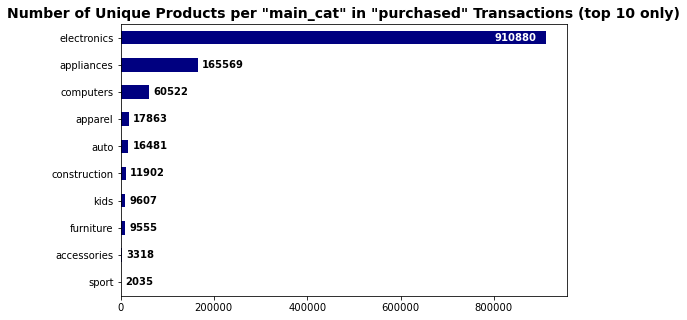

In [14]:
plot_products_per_category(purchase_df, category='main_cat', action='purchased')

<center><span style="font-size:14px"><b>Figure 4. </b>Number of Unique Products per Main Category in 'purchase' Transactions</span></center>

The top three main categories in terms of the number of purchases are `electronics`, `appliances`, and `computers`, and beyond them, the number of products purchased fall drastically. It might be better to lump these categories with low number of purchases into one category called `others` when making further analyses.

##### Sub Category 1

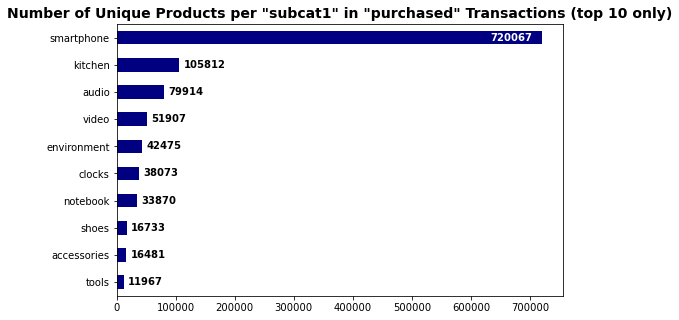

In [15]:
plot_products_per_category(purchase_df, category='subcat1', action='purchased')

<center><span style="font-size:14px"><b>Figure 5. </b>Number of Unique Products per Sub Category 1 in 'purchase' Transactions</span></center>

The plot shows that in terms of purchases under subcategory 1, smartphone tops the list, with kitchen and computer products as the distant second and third placers, respectively. This is much in line with the current trend of many people replacing their smartphones more often than any other electronic device or appliance.

##### Sub Category 2

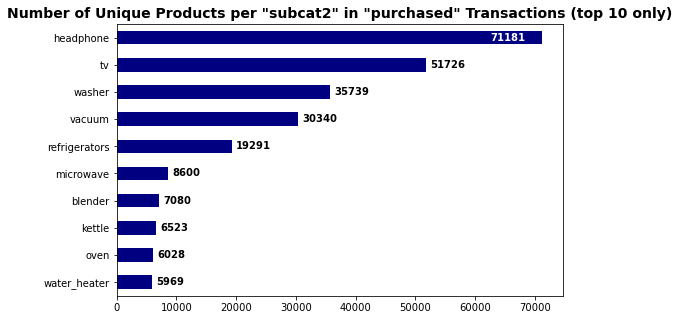

In [16]:
plot_products_per_category(purchase_df, category='subcat2', action='purchased')

<center><span style="font-size:14px"><b>Figure 6. </b>Number of Unique Products per Sub Category 2 in 'purchase' Transactions</span></center>

The plot shows that under sub-category 2, the most commonly bought items are headphones, tv, washers, vacuum cleaners, and refrigerators, and the number of purchases exhibits a sharp drop onwards. This shows that the bulkiness of the items could be one of the factors that affect the sales of items under this category.

##### Sub Category 3

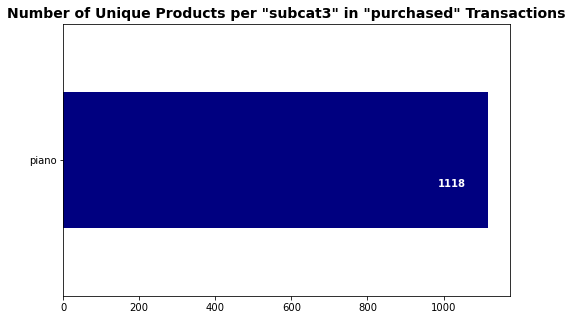

In [17]:
plot_products_per_category(purchase_df, category='subcat3', action='purchased')

<center><span style="font-size:14px"><b>Figure 7. </b>Number of Unique Products per Sub Category 3 in 'purchase' Transactions</span></center>

The plot shows a single item in subcategory 3 --- piano. With a very low number of purchases in its own subcategory, this indicates that with the consumption of digital media where smartphones top the purchase list, more people are losing interest in buying expensive, heavy, and bulky 'analog' musical instruments such as the piano.

#### D. Insights on EDA

The team assumed that the number of `cart` transactions is far greater than the number of `purchase` transaction. Which is why the team initially intended to create a separate analysis on `cart` and `purchase` transactions then try to find any relationships or correlations between the results of each analysis. 

However, based on the resulting plots above, overall, the number of transactions between the two transactions are almost the same. For this reason, the team did not pursue any further to do analysis on the `cart` transactions because it can be assumed that the frequent items added-to-cart are also the items bought by the users.

Moving forward, focusing on the `purchase` transactions, it shows that the `main categories` is dominated by the categories `electronics`, `appliances`, and `computers`. The team assumed that with the highly imbalanced data on the categories, the frequent itemset mining analysis will mainly show items from these categories.

The team would want to do a more holistic study on the data. For this reason, the team aggregated the minor categories into one category called `others`. Thus, resulting to the major category elements: **`electronics`**, **`appliances`**, **`computers`**, and **`others`**.

#### E. Creating the Major Categories and Performing EDA

##### Major Categories Overview

In [18]:
purchase_df['major_cat'] = purchase_df['main_cat'].apply(get_major_cats)

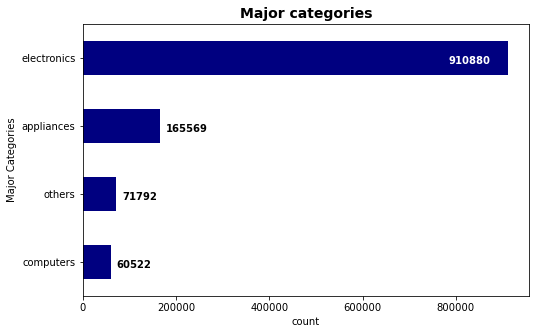

In [19]:
plt.figure(figsize=(8, 5))

result = purchase_df['major_cat'].value_counts()
result.plot(kind='barh', color=c_darkblue).invert_yaxis()
length = len(result)

for i in range(length):
        max_x = max(result.tolist())
        if result.tolist()[i] > max_x / 2:
            plt.text(result.tolist()[i]-(max_x*0.14), i+0.09, 
                     result.tolist()[i], color='white', fontsize=10,
                     weight='bold')
        else: 
            plt.text(result.tolist()[i]+(max_x*0.014), i+0.09, 
                     result.tolist()[i], color='black', fontsize=10,
                     weight='bold')

plt.title('Major categories', fontsize=14, weight='bold')
plt.xlabel('count')
plt.ylabel('Major Categories')
plt.show();

<center><span style="font-size:14px"><b>Figure 8. </b>Purchase Count per Major Category</span></center>

Electronics came out on top in terms of the number of purchases, beating appliances, computers, and others by a large margin.  As these categories are further broken down, a reason why the current trend behaves this way will become apparent. 

##### Electronics

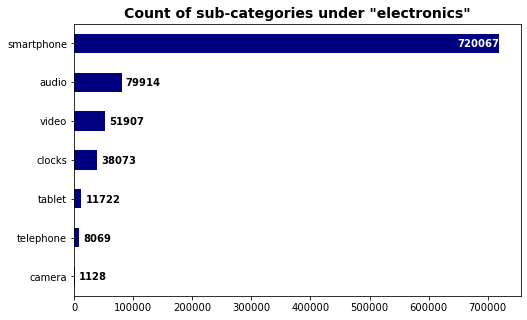

In [20]:
mask = purchase_df['major_cat']=='electronics'
plot_major_categories(purchase_df, 'electronics')

<center><span style="font-size:14px"><b>Figure 9. </b>Purchase Count per Sub Category under Electronics</span></center>

Smartphone tops the number of purchases in the electronics category by a large margin. This demonstrates the power of the modern smartphone because it can do the functions of the other electronic devices given in the plot.

##### Appliances

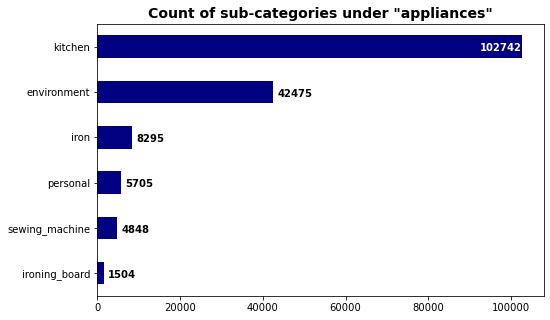

In [21]:
plot_major_categories(purchase_df, 'appliances')

<center><span style="font-size:14px"><b>Figure 10. </b>Purchase Count per Sub Category under Appliances</span></center>

The plot shows that the majority of the purchases were for kitchen and cleaning appliances. This might represent a shift in preferences of people in the modern world as there is less interest in ironing and repairing clothes, that is, activities which are more prevalent two generations ago.

##### Computers

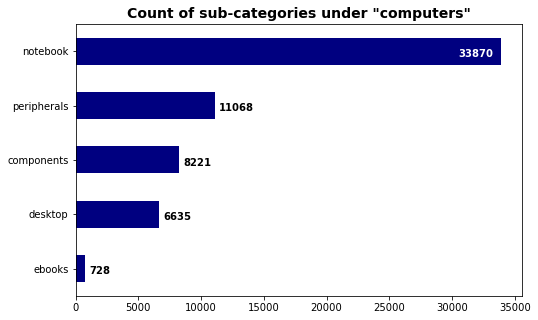

In [22]:
plot_major_categories(purchase_df, 'computers')

<center><span style="font-size:14px"><b>Figure 11. </b>Purchase Count per Sub Category under Computers</span></center>

The plot shows that laptops are the top-selling under the Computer category. The increasing processing power of the current laptops has whittled down the sales of desktop computers, and the rise of online platforms could have rendered most peripherals as low-priority items as well. 

##### Others

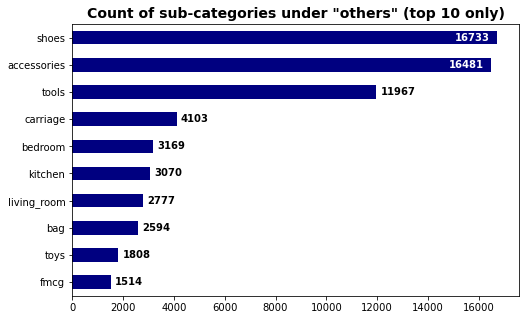

In [23]:
plot_major_categories(purchase_df, 'others')

<center><span style="font-size:14px"><b>Figure 12. </b>Purchase Count per Sub Category under Others</span></center>

In terms of non-electronic items, shoes, and accessories top the list, followed by hand tools. This makes sense as these are considered analog items, the literal opposite of digital.

<a id='FIM'></a>
<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">Frequent Itemset Mining</h2>

The analysis is segmented by categories because from **Figure 3.**, `electronics` products are drastically more purchased than the other categories. The team segment by four categories, namely:

1. `electronics`
1. `computers`
1. `appliances`
1. `others` which contain the following categories `apparel`, `auto`, `construction`, `furniture`, `kids`, `accessories`, `sport`, `medicine`, `stationery`, `country_yard`

Moreover, for each category, we perform two implementations of FIM based on the following criteria:
1. Frequent Itemset Mining with `category_code` as the **items** and `user_session` as the **transactions**. 
1. Frequent Itemset Mining with `brand` + `category_code` as the **items** and `user_session` as the **transactions**. 

In particular, we extract frequent itemsets as well as association rules from the above criteria. Relevant insights are extracted from the respective implementations and are discussed below.

**Note:** In this section, the team will only show a demonstration of the FIM pipeline for the `electronics category`. The reader may refer to the **Appendix** to view the results for the other categories.

####  A. FIM via `category_code`

In [24]:
db_dict = dict(table='purchases', main_cat='electronics')
supp = -20

db = build_category_code_db(**db_dict)
discard_supp(display_frequent_itemsets(db, supp, 1))

Object pickled for future use.


(('smartphone',),
 ('headphone',),
 ('tv',),
 ('clocks',),
 ('tablet',),
 ('telephone',),
 ('subwoofer',),
 ('headphone', 'smartphone'),
 ('smartphone', 'tv'),
 ('clocks', 'smartphone'))

In [25]:
discard_supp(display_frequent_itemsets(db, supp, 2))

(('headphone', 'smartphone'),
 ('smartphone', 'tv'),
 ('clocks', 'smartphone'),
 ('clocks', 'headphone'),
 ('smartphone', 'tablet'),
 ('smartphone', 'telephone'),
 ('smartphone', 'subwoofer'),
 ('headphone', 'tv'),
 ('clocks', 'headphone', 'smartphone'),
 ('clocks', 'tv'))

In [26]:
discard_supp(display_frequent_itemsets(db, supp, 3))

(('clocks', 'headphone', 'smartphone'), ('headphone', 'smartphone', 'tv'))

####  A. FIM via `brand` and `category_code`

In [27]:
db = build_brand_category_code_db(**db_dict)
discard_supp(display_frequent_itemsets(db, supp, 1))

Object pickled for future use.


(('samsung.smartphone',),
 ('apple.smartphone',),
 ('xiaomi.smartphone',),
 ('huawei.smartphone',),
 ('apple.headphone',),
 ('oppo.smartphone',),
 ('samsung.tv',),
 ('apple.clocks',),
 ('xiaomi.headphone',),
 ('artel.tv',))

In [28]:
discard_supp(display_frequent_itemsets(db, supp, 2))

(('apple.smartphone', 'samsung.smartphone'),
 ('samsung.smartphone', 'xiaomi.smartphone'),
 ('huawei.smartphone', 'samsung.smartphone'),
 ('apple.headphone', 'apple.smartphone'),
 ('oppo.smartphone', 'samsung.smartphone'),
 ('apple.clocks', 'apple.smartphone'),
 ('apple.smartphone', 'xiaomi.smartphone'),
 ('huawei.smartphone', 'xiaomi.smartphone'),
 ('apple.smartphone', 'huawei.smartphone'),
 ('samsung.smartphone', 'samsung.tv'))

In [29]:
(discard_supp(display_frequent_itemsets(db, supp, 3)))

(('apple.smartphone', 'samsung.smartphone', 'xiaomi.smartphone'),
 ('huawei.smartphone', 'samsung.smartphone', 'xiaomi.smartphone'),
 ('apple.smartphone', 'huawei.smartphone', 'samsung.smartphone'),
 ('oppo.smartphone', 'samsung.smartphone', 'xiaomi.smartphone'),
 ('apple.smartphone', 'oppo.smartphone', 'samsung.smartphone'),
 ('huawei.smartphone', 'oppo.smartphone', 'samsung.smartphone'),
 ('apple.clocks', 'apple.headphone', 'apple.smartphone'),
 ('apple.headphone', 'apple.smartphone', 'samsung.smartphone'),
 ('apple.clocks', 'apple.smartphone', 'samsung.smartphone'),
 ('apple.smartphone', 'lg.tv', 'samsung.smartphone'))

In [30]:
get_assoc_rules(db)

consequent  \
0  samsung.smartphone   
1  samsung.smartphone   

                                                 antecedent      lift  
0    (apple.smartphone, oppo.smartphone, xiaomi.smartphone)  2.001163  
1  (apple.smartphone, huawei.smartphone, xiaomi.smartphone)  1.774675

[Back to TOC](#TContents)

<a id='Results'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">RESULTS AND DISCUSSION</h1>

<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">A. Electronics</h2>

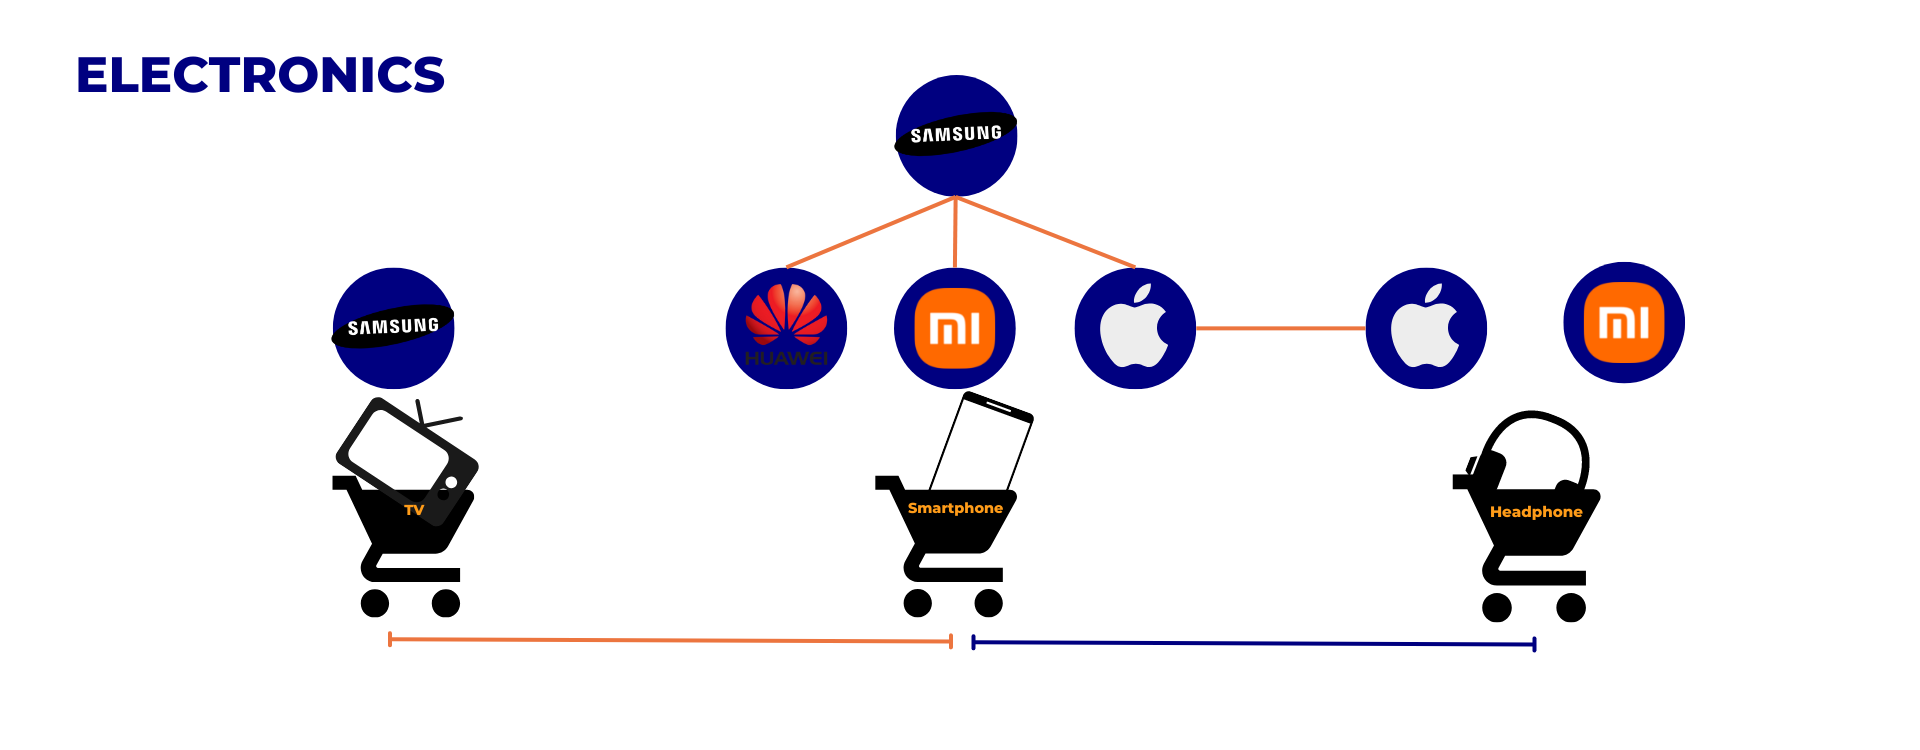
<center><span style="font-size:14px"><b>Figure 13. </b>Results for the Electronics Main Category</span></center>

- **Smartphones**, **headphones**, **televisions** are the most frequently purchased items in the `electronics` category.
- Headphones are frequently purchased with smartphones, smartphones are frequently purchased with televisions, and clocks are also purchased with smartphones often.
- Apart from purchases including different brands of smartphones, there are also Apple product combinations that are are frequently purchased.
- The most frequently purchased products are different brands of smartphones such as Samsung, Apple, Xiaomi, Huawei, and Oppo. Apple airpods (headphones) and Apple watches (clocks) are also frequently purchased products.
- Association rules show that a customer who buys three of the top brands of smartphones are highly likely to also purchase a fourth one, i.e., Samsung. This implies that a lot of smartphone-buying customers may be resellers of different products.

This makes sense since smartphones bridge the gap between TV and headphones since smartphones are audio-visual products. The business owner should frequently consider offering promotions for smartphones and accessory purchases. Moreover, offering discounts on bulk orders may also entice new customers to become frequent buyers, that is, to instill customer loyalty.

<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">B. Appliances</h2>

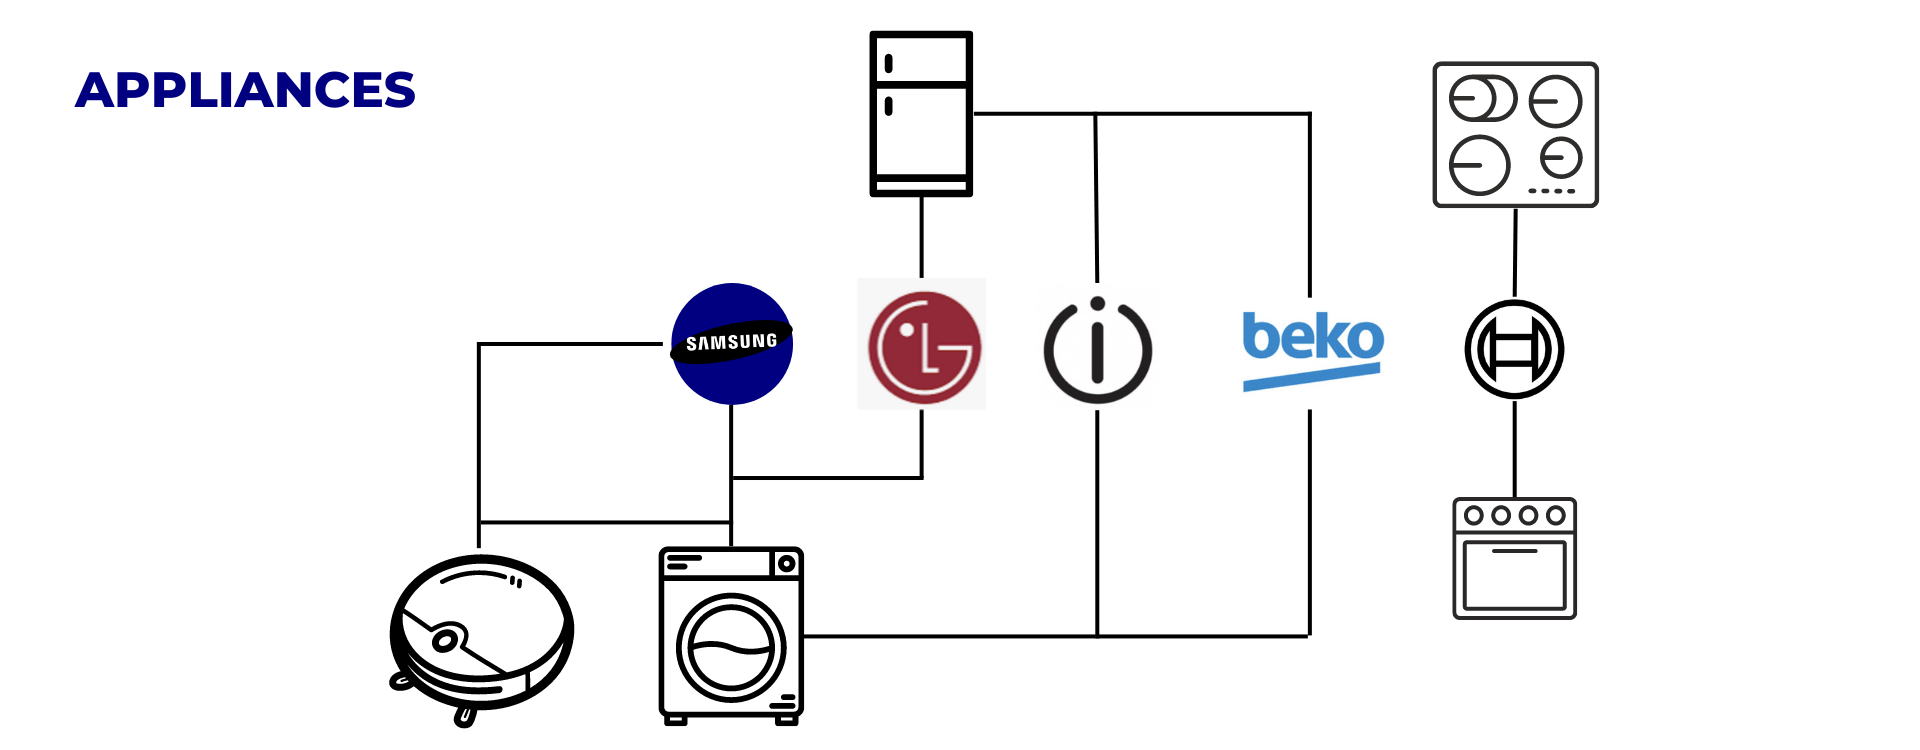
<center><span style="font-size:14px"><b>Figure 14. </b>Results for the Appliances Main Category</span></center>

- **Washers**, **vacuums**, **refrigerators**, **heaters**, and **microwaves** are among the most frequently purchased products in the appliances category.

- Refrigators are frequently bought with washers. The same is true for vacuums and washers.

- Samsung, LG, Indesit, Beko are among the most frequently sought after brands in the appliances category.

- Association rules show that there is a high likelihood that a customer who purchases a dishwasher and oven will also purchase a hub. Another rule also states that a customer buying a hob, refrigerator, and washer together is likely to purchase an oven.

Brand loyalty is apparent, as appliances of the same brand are frequently bought together, or at least there is similarity in the country of origin of the brands. Combinations of products often occur among the dominating brands due to their reputation. The business owner may focus on stocking up on products of these leading brands to encourage more sales.

<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">C. Computers</h2>

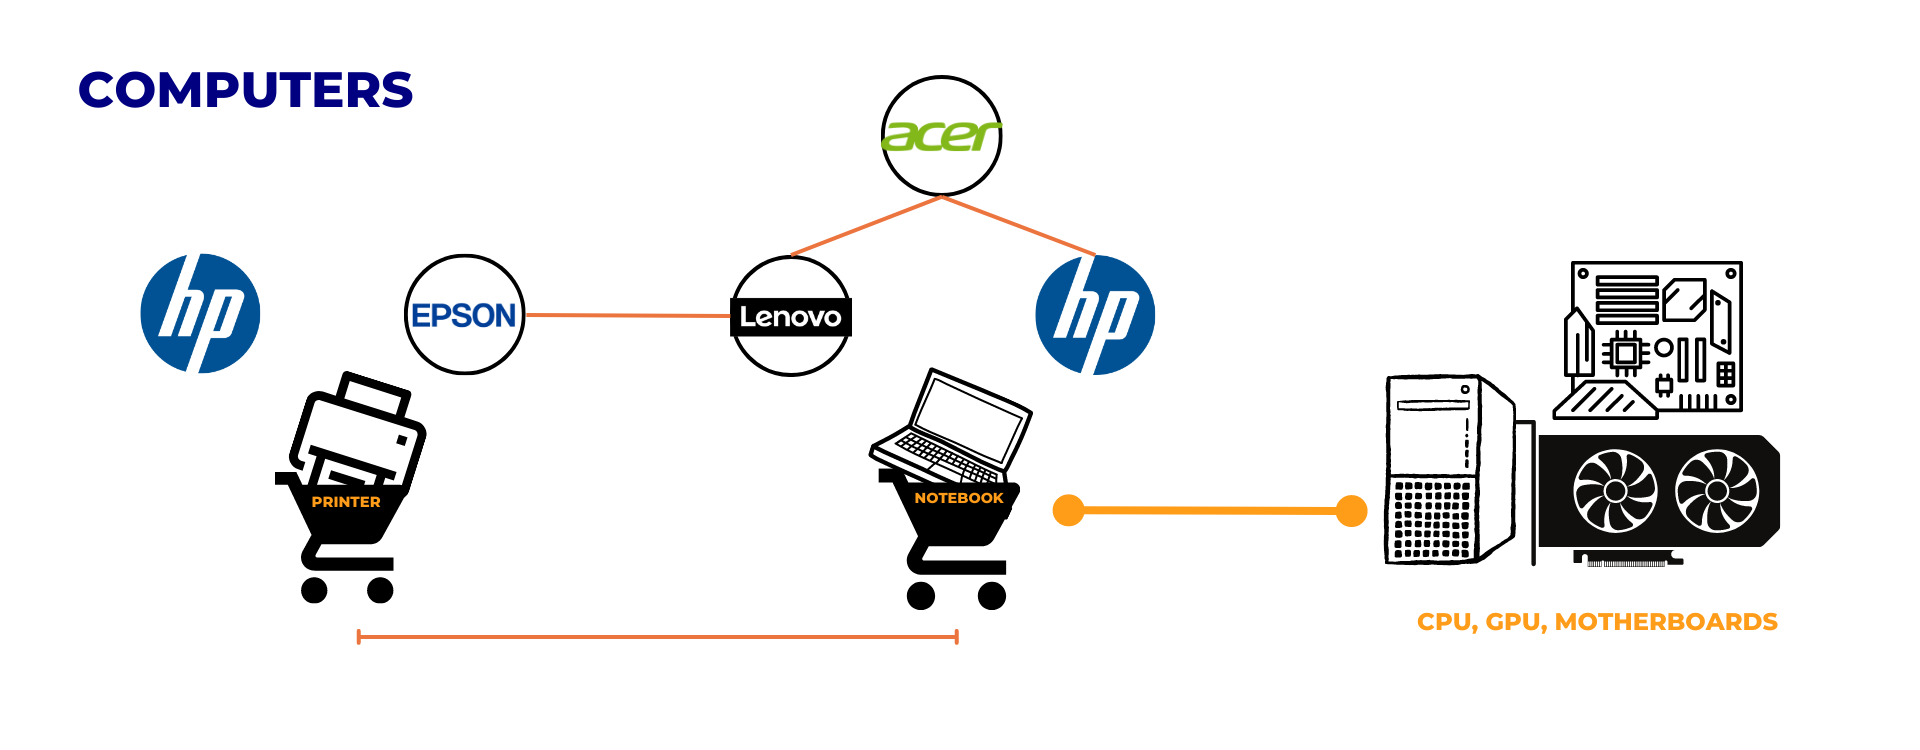
<center><span style="font-size:14px"><b>Figure 15. </b>Results for the Computers Main Category</span></center>

As for the computers results, based on the illustration above, the following points can be observed and inferred:

- **Printers** and **notebooks** (laptops) are sub categories of computers which are frequently bought together.
- The most frequent printer brands bought are **HP** and **Epson**, but the latter is the only one which is bought together with Lenovo notebooks. 
- Buying a printer and notebook together makes sense, especially in the perspective of students who are constantly required to submit hard copy papers. 
- For notebooks, **Acer** brand is frequently bought together with either **Lenovo** or **HP**.
- Generally, Acer is considered cheaper than Lenovo and HP, it can be inferred that the combination Acer and Lenovo along with Acer and HP are both frequently purchased together to combine low-end and high-end products.

It is worth noting that printers are complementary to both desktops and laptops and therefore appears as part of frequent itemsets. The business owner can stock up on more brands of printers and printer accessories to leverage the demand on printers. Although the support is considerably lower, the team also notes that computer parts such as CPU, videocards, memory, and motherboards are highly likely to be purchased together based on association rules.

<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">D. Others</h2>

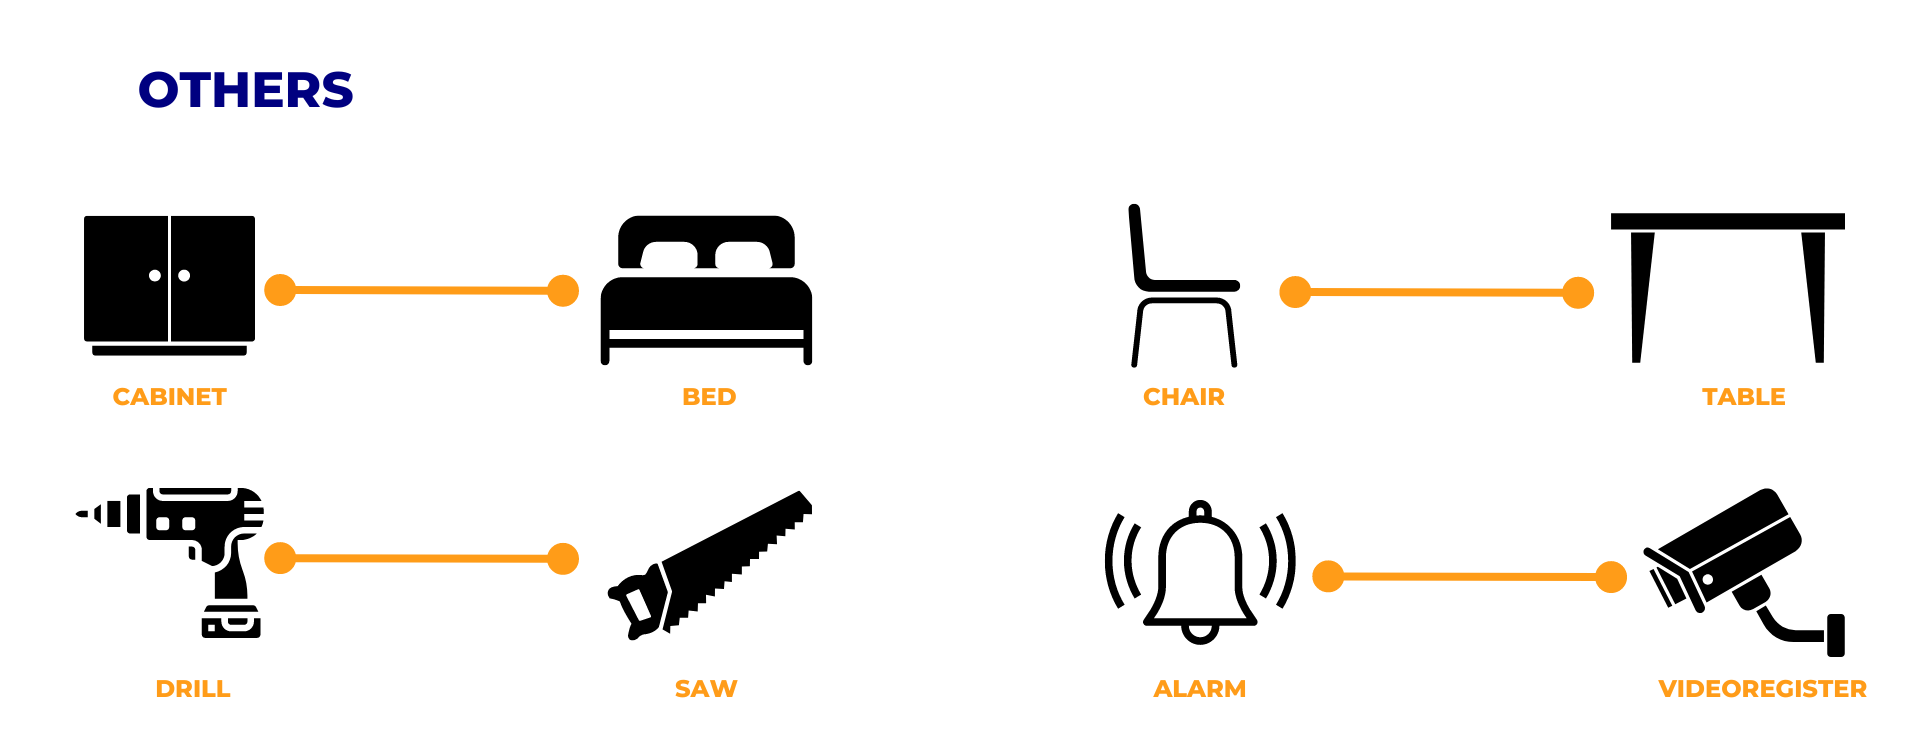
<center><span style="font-size:14px"><b>Figure 16. </b>Results for the Others Main Category</span></center>

For the results in the Others category, due to limited data it has compared to other major categories, the brand-category FIM results were insufficient to derive association patterns. Therefore, the analysis for this result is limited only to the `category_code` criteria. The following could be observed from the illustration above:
- **Cabinets** are frequently bought together with **beds**.
- **Drills** are frequently bought together with **saw**.
- **Chairs** are frequently bought together with **tables**.
- **Alarms** are frequently bought together with **videoregisters** (aka video or security cameras).

Based on the results above, it can be inferred that in the Others category, products that are frequently bought together are products that are complementary with each other. This means that for this category business owner should consider grouping together products of similar or complementary utilities, especially in the context of home improvement.

<a id='Recommendation1'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">RECOMMENDATION</h1>

<a id='Limitations'></a>
<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">Limitations of the Study</h2>

The following list outlines some of the assumptions and limitations of the dataset used in this analysis: - There is no description on the products.
- The dataset has no data on user reviews and user demographics.
- The team only focused on `purchase` transactions and did not consider any other `event_types`
- The team only focused on doing analysis on the frequently bought brands and categories and no extensive cross-analysis was made in relation to its prices.

<a id='Recommendation2'></a>
<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">Recommendation</h2>

Based on the results, the business owner could leverage the information and perform the following to encourage business growth:
- **Market basket analysis:** Frequent itemset mining can help identify the items that are frequently bought together by customers. This information can be used for market basket analysis, which can be used to suggest complementary products to customers and improve cross-selling and upselling. In this case, *laptop notebooks* and *printers* are frequently bought together. The business owner could create promotions bundling these two products to increase sales.

- **Inventory management:** By identifying the frequently bought items, retailers can ensure that they always have sufficient stock of those items, leading to better inventory management and reducing the likelihood of stockouts. In particular, there is a significant amount of demand for smartphone products of varying brands. The business owner must keep stock of such products in order to maximize their sales.

- **Personalization:** By analyzing the frequent itemsets, retailers can gain insight into the preferences of their customers, allowing them to personalize their marketing efforts and provide more relevant product recommendations to their customers. By obtaining association patterns across different brands, the business owner may sell products of different brands together to increase sales.

<a id='FutureWork'></a>
<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">Future Work</h2>

For future researchers interested in using this dataset, the following works are suggested for improvement: - Consider expanding the study including **view**, **cart** and **remove** transaction event types in order to capture the overall shopping patterns of the users. 
- Consider creating a separate study on 'sale promotional events' to analyze the effect of such events to the business and how does this shift the behavior of the user.
- Consider doing cross-analysis between the frequently bought items and the prices. Frequent itemset mining can also be used to identify the price points at which customers are most likely to buy certain items. This information can be used to optimize pricing strategies and increase sales.

[Back to TOC](#TContents)

<a id='Conclusion'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">CONCLUSION</h1>

In creating this study, the team attempted to uncover the frequently bought product brands and categories. To attain such objective, the team did Frequent Itemset Mining (FIM) Analysis. But before the FIM Analysis was implemented, the team had to narrow down the study from `cart` and `purchase` event_type analysis to `purchase` event_type analysis only. Furthermore, the team narrowed down the product categories to four (4) Major Categories: `electronics`, `appliances`, `computer`, and `others`. The results show that that for each category, the FIM analysis was limited to identifying frequent 2-itemsets, and only a few categories extended to 3-itemsets results. Some results are not surprising such as Apple smartphones and Apple headphones are frequently bought together since in reality, Apple products are known for its exclusivity. The assumptions and limitations of the dataset were acknowledged, and future work was identified to enhance the performance of the recommendation system. Overall, the team had successfully determined the frequently bought product brands and categories albeit the limitation of not having product descriptions.

[Back to TOC](#TContents)

<a id='Results'></a>
<h1 style="color:#ffffff; background-color:#000080; border: 1px solid #ffffff; padding: 10px 0;">APPENDIX</h1>

<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">B. Appliances</h2>

### <u>FIM via `category_code`</u>

In [31]:
db_dict = dict(table='purchases', main_cat='appliances')
supp = -20

db = build_category_code_db(**db_dict)
display_frequent_itemsets(db, supp, 1)

Object pickled for future use.


[(('washer',), 32120),
 (('vacuum',), 28494),
 (('refrigerators',), 17597),
 (('heater',), 10169),
 (('microwave',), 8152),
 (('iron',), 7931),
 (('blender',), 6765),
 (('kettle',), 6209),
 (('machine',), 5677),
 (('oven',), 5630)]

In [32]:
display_frequent_itemsets(db, supp, 2)

[(('refrigerators', 'washer'), 607),
 (('vacuum', 'washer'), 415),
 (('hob', 'oven'), 316),
 (('iron', 'vacuum'), 276),
 (('microwave', 'vacuum'), 222),
 (('refrigerators', 'vacuum'), 183),
 (('board', 'iron'), 169),
 (('hob', 'hood'), 153),
 (('heater', 'washer'), 131),
 (('microwave', 'washer'), 122)]

In [33]:
display_frequent_itemsets(db, supp, 3)

[(('hob', 'hood', 'oven'), 69),
 (('refrigerators', 'vacuum', 'washer'), 37),
 (('hob', 'oven', 'refrigerators'), 31),
 (('oven', 'refrigerators', 'washer'), 31),
 (('hob', 'oven', 'washer'), 30),
 (('dishwasher', 'hob', 'oven'), 27),
 (('hob', 'refrigerators', 'washer'), 22)]

In [34]:
get_assoc_rules(db)

consequent                    antecedent       lift
0        hob            (dishwasher, oven)  41.661656
1       oven  (hob, refrigerators, washer)  17.950832

### <u>FIM via `brand` and `category_code`</u>

In [35]:
db = build_brand_category_code_db(**db_dict)
display_frequent_itemsets(db, supp, 1)

Object pickled for future use.


[(('samsung.vacuum',), 10774),
 (('samsung.washer',), 10398),
 (('lg.washer',), 6215),
 (('indesit.washer',), 5006),
 (('indesit.refrigerators',), 4294),
 (('beko.washer',), 3598),
 (('bosch.vacuum',), 3385),
 (('ariston.heater',), 3221),
 (('midea.washer',), 3052),
 (('janome.machine',), 2821)]

In [36]:
display_frequent_itemsets(db, supp, 2)

[(('lg.washer', 'samsung.washer'), 131),
 (('beko.washer', 'indesit.washer'), 87),
 (('lg.refrigerators', 'lg.washer'), 86),
 (('beko.washer', 'samsung.washer'), 85),
 (('samsung.vacuum', 'samsung.washer'), 84),
 (('indesit.washer', 'samsung.washer'), 77),
 (('bosch.hob', 'bosch.oven'), 69),
 (('indesit.refrigerators', 'samsung.washer'), 59),
 (('beko.refrigerators', 'indesit.refrigerators'), 54),
 (('lg.refrigerators', 'samsung.washer'), 53)]

In [37]:
display_frequent_itemsets(db, supp, 3)

[]

In [38]:
get_assoc_rules(db)

Empty DataFrame
Columns: [consequent, antecedent, lift]
Index: []

<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">C. Computers</h2>

### <u>FIM via `category_code`</u>

In [39]:
db_dict = dict(table='purchases', main_cat='computers')
supp = -20

db = build_category_code_db(**db_dict)
display_frequent_itemsets(db, supp, 1)

Object pickled for future use.


[(('notebook',), 29946),
 (('desktop',), 6077),
 (('printer',), 4814),
 (('monitor',), 2334),
 (('hdd',), 2128),
 (('mouse',), 1897),
 (('videocards',), 1720),
 (('keyboard',), 1088),
 (('memory',), 1019),
 (('cooler',), 907)]

In [40]:
display_frequent_itemsets(db, supp, 2)

[(('notebook', 'printer'), 146),
 (('cpu', 'motherboard'), 139),
 (('desktop', 'notebook'), 90),
 (('desktop', 'monitor'), 81),
 (('memory', 'motherboard'), 75),
 (('keyboard', 'mouse'), 72),
 (('cpu', 'memory'), 68),
 (('hdd', 'memory'), 68),
 (('cpu', 'videocards'), 60),
 (('motherboard', 'videocards'), 52)]

In [41]:
display_frequent_itemsets(db, supp, 3)

[(('cpu', 'memory', 'motherboard'), 47),
 (('cpu', 'motherboard', 'videocards'), 35),
 (('cpu', 'motherboard', 'supply'), 30),
 (('cpu', 'hdd', 'motherboard'), 26),
 (('cpu', 'memory', 'videocards'), 22),
 (('memory', 'motherboard', 'videocards'), 20)]

In [42]:
get_assoc_rules(db)

consequent                         antecedent       lift
0           cpu  (memory, motherboard, videocards)  66.386250
1   motherboard                      (cooler, cpu)  64.740756
2           cpu             (monitor, motherboard)  61.335122
3   motherboard          (cpu, memory, videocards)  60.163127
4           cpu              (motherboard, supply)  59.273438
5   motherboard                     (cpu, monitor)  58.596379
6   motherboard                      (cpu, memory)  57.177089
7           cpu          (motherboard, videocards)  55.853816
8   motherboard                      (cpu, supply)  55.149533
9           cpu              (memory, motherboard)  52.002563
10          cpu                 (hdd, motherboard)  51.370312
11  motherboard                         (cpu, hdd)  51.210280
12   videocards                     (cpu, monitor)  19.298328

### <u>FIM via `brand` and `category_code`</u>

In [43]:
db = build_brand_category_code_db(**db_dict)
display_frequent_itemsets(db, supp, 1)

Object pickled for future use.


[(('acer.notebook',), 10255),
 (('lenovo.notebook',), 8900),
 (('hp.notebook',), 4459),
 (('asus.notebook',), 3890),
 (('epson.printer',), 2435),
 (('apple.notebook',), 2205),
 (('zeta.desktop',), 1445),
 (('hp.printer',), 1228),
 (('pulser.desktop',), 901),
 (('kingston.hdd',), 871)]

In [44]:
display_frequent_itemsets(db, supp, 2)

[(('acer.notebook', 'lenovo.notebook'), 214),
 (('acer.notebook', 'asus.notebook'), 123),
 (('hp.notebook', 'lenovo.notebook'), 123),
 (('acer.notebook', 'hp.notebook'), 117),
 (('asus.notebook', 'lenovo.notebook'), 78),
 (('asus.notebook', 'hp.notebook'), 28),
 (('acer.notebook', 'apple.notebook'), 25),
 (('epson.printer', 'lenovo.notebook'), 25),
 (('amd.cpu', 'asrock.motherboard'), 23),
 (('gigabyte.motherboard', 'intel.cpu'), 22)]

In [45]:
display_frequent_itemsets(db, supp, 3)

[]

In [46]:
get_assoc_rules(db)

Empty DataFrame
Columns: [consequent, antecedent, lift]
Index: []

<h2 style="color:#000080; background-color:#ffffff; border: 1px solid #000080; padding: 10px 0;">D. Others</h2>

### <u>FIM via `category_code`</u>

In [47]:
db_dict = dict(table='purchases', main_cat='others')
supp = -20

db = build_category_code_db(**db_dict)
display_frequent_itemsets(db, supp, 1)

Object pickled for future use.


[(('shoes',), 11020),
 (('alarm',), 5372),
 (('player',), 4900),
 (('keds',), 4041),
 (('drill',), 3822),
 (('carriage',), 3801),
 (('videoregister',), 3771),
 (('saw',), 2747),
 (('chair',), 2736),
 (('generator',), 2700)]

In [48]:
display_frequent_itemsets(db, supp, 2)

[(('keds', 'shoes'), 101),
 (('drill', 'saw'), 44),
 (('chair', 'table'), 34),
 (('bed', 'cabinet'), 31),
 (('alarm', 'videoregister'), 31),
 (('radar', 'videoregister'), 25),
 (('alarm', 'player'), 22)]

In [49]:
display_frequent_itemsets(db, supp, 3)

[]

In [50]:
get_assoc_rules(db)

Empty DataFrame
Columns: [consequent, antecedent, lift]
Index: []

### <u>FIM via `brand` and `category_code`</u>

In [51]:
db = build_brand_category_code_db(**db_dict)
display_frequent_itemsets(db, supp, 1)

Object pickled for future use.


[(('respect.shoes',), 4887),
 (('starline.alarm',), 4435),
 (('pioneer.player',), 2379),
 (('baden.shoes',), 1782),
 (('huter.saw',), 1340),
 (('sho-me.videoregister',), 1328),
 (('belecoo.carriage',), 1264),
 (('bosch.drill',), 1095),
 (('tefal.generator',), 983),
 (('rieker.shoes',), 860)]

In [52]:
display_frequent_itemsets(db, supp, 2)

[(('baden.shoes', 'respect.shoes'), 79),
 (('respect.shoes', 'rieker.shoes'), 37)]

In [53]:
display_frequent_itemsets(db, supp, 3)

[]

In [54]:
get_assoc_rules(db)

Empty DataFrame
Columns: [consequent, antecedent, lift]
Index: []

[Back to TOC](#TContents)

<a id='References'></a>
# References

[1] https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/discussion/193218 <br>
[2] https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/discussion/364799 <br>
[3] https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store

**END**

[Back to TOC](#TContents)